# Emotion Recognition Fine Tuning

## Objective:

I'll use a [Vision Transformer (ViT)](https://huggingface.co/google/vit-base-patch16-224-in21k) model pre-trained on ImageNet-21k and fine-tune it on the [FastJobs/Visual_Emotional_Analysis](https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis) dataset for emotion recognition.

### Step 1: Environment Setup

In [ ]:
# Install necessary packages

!pip install transformers datasets evaluate huggingface_hub gradio

In [ ]:
# Log into Hugging Face's platform

from huggingface_hub import login

login()

### Step 2: Load the Dataset

Load the [FastJobs/Visual_Emotional_Analysis](https://huggingface.co/datasets/FastJobs/Visual_Emotional_Analysis) dataset and split it into training and test sets with a test size of 0.2.

In [ ]:
# Load the dataset and split it
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from datasets import Dataset

emotion = load_dataset("FastJobs/Visual_Emotional_Analysis", split="train[:]")

print(emotion)

emotion = emotion.train_test_split(test_size=0.2, seed=42)

emotion["train"][0]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Resolving data files:   0%|          | 0/800 [00:00<?, ?it/s]

Dataset({
    features: ['image', 'label'],
    num_rows: 800
})


{'image': <PIL.PngImagePlugin.PngImageFile image mode=RGB size=96x96>,
 'label': 1}

**Label Mapping**

In [ ]:
labels = emotion["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

### Step 3: Explore and Visualize the Dataset

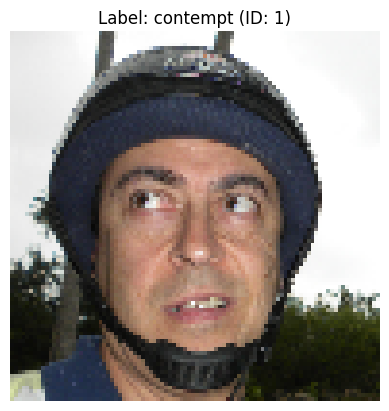

In [ ]:
import matplotlib.pyplot as plt

# Define the function to convert label index to label name
id2label_view = {str(i): label for i, label in enumerate(labels)}

# Use first training example
image = emotion['train'][0]['image'] # Explore image by index
label_id = str(emotion['train'][0]['label'])
label_name = id2label_view[label_id]

# Display the image and its corresponding label
plt.imshow(image)
plt.title(f'Label: {label_name} (ID: {label_id})')
plt.axis('off')
plt.show()

### Step 4: Preprocess the Data

In [ ]:
from transformers import AutoImageProcessor
from torchvision.transforms import RandomResizedCrop, Compose, Normalize, ToTensor

# Load the image processor, Define the transforms, Define the transformation function and Apply the transformation function
checkpoint = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

normalize = Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
size = (
    image_processor.size["shortest_edge"]
    if "shortest_edge" in image_processor.size
    else (image_processor.size["height"], image_processor.size["width"])
)
_transforms = Compose([RandomResizedCrop(size), ToTensor(), normalize])

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


### Step 5: Model Setup

In [ ]:
from transformers import AutoModelForImageClassification

# Define the model
model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
def transforms(examples):
    examples["pixel_values"] = [_transforms(img.convert("RGB")) for img in examples["image"]]
    del examples["image"]
    return examples

emotion = emotion.with_transform(transforms)

### Step 6: Training Setup

Define the training arguments and instantiate the trainer.

In [ ]:
import evaluate

# Load accuracy metric
accuracy = evaluate.load("accuracy")

In [ ]:
import numpy as np

# Define compute metric function
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [ ]:
from transformers import TrainingArguments, Trainer, AdamW, get_linear_schedule_with_warmup

# Define training arguments
training_args = TrainingArguments(
    output_dir="model/image_classification",
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,                 # learning rate
    per_device_train_batch_size=16,     # training batch size
    gradient_accumulation_steps=4,      # to simulate a larger batch size
    per_device_eval_batch_size=16,      # evaluation batch size
    num_train_epochs=15,                # total number of training epochs
    warmup_ratio=0.1,                   # learning rate warmup ratio
    logging_steps=10,
    load_best_model_at_end=True,        # model optimization via early stopping
    metric_for_best_model="accuracy",
    seed=42,                            # set seed for reproducibility
    push_to_hub=True,                   # upload to Hugging Face Model Hub
)

# Initialize the optimizer
optimizer = AdamW(
    model.parameters(),
    lr=training_args.learning_rate,
    betas=(0.9, 0.999),
    eps=1e-08
)

# Setup the learning rate scheduler
lr_scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(training_args.warmup_ratio * len(emotion["train"])),
    num_training_steps=len(emotion["train"]) // training_args.per_device_train_batch_size * training_args.num_train_epochs
)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1494: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


use Hugging Face `Trainer`, have to install the `accelerate` library version `0.20.1` or later. It is used for performance enhancement on PyTorch.

In [ ]:
%pip install accelerate -U

In [ ]:
from transformers import DefaultDataCollator

data_collator = DefaultDataCollator()

# Instantiate the trainer
trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=data_collator,
    train_dataset=emotion["train"],
    eval_dataset=emotion["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, lr_scheduler)  # Pass the optimizer and scheduler
)

### Step 7: Train and Evaluate the Model

In [ ]:
# Train the model
trainer.train()
# print(trainds[0])

Epoch,Training Loss,Validation Loss,Accuracy
1,2.070200,2.066555,0.143750
2,2.058300,2.047583,0.212500
3,2.029100,2.001846,0.300000
4,1.963900,1.917478,0.356250
5,1.858200,1.799660,0.437500
6,1.738500,1.675592,0.462500
7,1.598400,1.546933,0.462500
8,1.473900,1.468445,0.518750
9,1.373700,1.409036,0.512500
10,1.271900,1.373973,0.525000


TrainOutput(global_step=150, training_loss=1.512528896331787, metrics={'train_runtime': 20257.5867, 'train_samples_per_second': 0.474, 'train_steps_per_second': 0.007, 'total_flos': 7.439631055847424e+17, 'train_loss': 1.512528896331787, 'epoch': 15.0})

In [ ]:
# Evaluate the model
eval_result = trainer.evaluate(eval_dataset=emotion["test"])
print(eval_result)

accuracy_str = "{:.4f}".format(eval_result["eval_accuracy"])

{'eval_loss': 1.2364068031311035, 'eval_accuracy': 0.59375, 'eval_runtime': 99.0666, 'eval_samples_per_second': 1.615, 'eval_steps_per_second': 0.101, 'epoch': 15.0}


### Step 8: Publishing the Trained Model

In [ ]:
trainer.push_to_hub()

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

events.out.tfevents.1725101937.3bcc1d917efc.4353.0:   0%|          | 0.00/13.3k [00:00<?, ?B/s]

events.out.tfevents.1725122328.3bcc1d917efc.4353.1:   0%|          | 0.00/411 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/izeeek/image_classification/commit/b0bd738de56f3bcfc11cc613bdc20da4c8f86554', commit_message='End of training', commit_description='', oid='b0bd738de56f3bcfc11cc613bdc20da4c8f86554', pr_url=None, pr_revision=None, pr_num=None)

### Step 9:  Build an Interactive Application with Gradio

In [ ]:
# Install Gradio
!pip install gradio

In [ ]:
import gradio as gr
from PIL import Image
from transformers import pipeline

def classify_image(input_image):
    age_classifier = pipeline("image-classification", model="nateraw/vit-age-classifier")
    emotion_classifier = pipeline("image-classification", model="izeeek/image_classification")

    img = Image.fromarray(input_image)

    age_results = age_classifier(img)
    age_highest_result = max(age_results, key=lambda x: x['score'])

    emotion_results = emotion_classifier(img)
    emotion_highest_result = max(emotion_results, key=lambda x: x['score'])

    return {"score": emotion_highest_result['score'], "label": emotion_highest_result['label']}, {"score": age_highest_result['score'], "label": age_highest_result['label']}

iface = gr.Interface(fn=classify_image, inputs="image", outputs=["json", "json"])
iface.launch()

Setting queue=True in a Colab notebook requires sharing enabled. Setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://0aa9f2fd2d58455d94.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)
